In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import json
import folium
from pyproj import Proj, transform
import mapclassify as mc
from shapely.geometry import Polygon
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs

In [25]:
restaurants = pd.read_csv('restaurants.csv', encoding='cp949')
restaurants

C:\Users\lotto\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (25,27,28,29,30,36,39,41,42) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,개방자치단체코드,관리번호,인허가일자,인허가취소일자,영업상태코드,영업상태명,상세영업상태코드,상세영업상태명,폐업일자,휴업시작일자,...,공장판매직종업원수,공장생산직종업원수,건물소유구분명,보증액,월세액,다중이용업소여부,시설총규모,전통업소지정번호,전통업소주된음식,홈페이지
0,3220000,3220000-101-2023-00456,2023-03-31,NaN,1,영업/정상,1,영업,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3220000,3220000-101-2023-00458,2023-03-31,NaN,1,영업/정상,1,영업,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3220000,3220000-101-2023-00459,2023-03-31,NaN,1,영업/정상,1,영업,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3220000,3220000-101-2023-00460,2023-03-31,NaN,1,영업/정상,1,영업,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3230000,3230000-101-2023-00220,2023-03-31,NaN,1,영업/정상,1,영업,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124854,3050000,3050000-101-2001-12875,20010716,NaN,1,영업/정상,1,영업,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124855,3100000,3100000-101-1997-01969,19970707,NaN,1,영업/정상,1,영업,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124856,3220000,3220000-101-1994-14896,19940917,NaN,1,영업/정상,1,영업,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124857,3020000,3020000-101-1988-00925,19880704,NaN,1,영업/정상,1,영업,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# X좌표 180000, Y좌표 435000을 (0, 0)으로 정의
# Grid 격자의 크기는 3000×3000으로 정의

x_tm = [180000 + 3000*x for x in range(0, 14)]
y_tm = [435000 + 3000*x for x in range(0, 12)]
x_grid = [x//12 for x in range(0, 168)]
y_grid = [x%12 for x in range(0,168)]
grid = pd.DataFrame([x_grid, y_grid], index=['x_grid', 'y_grid']).transpose()
grid['x_tm_start'] = [x_tm[grid.iloc[x, 0]] for x in range(0,168)]
grid['x_tm_end'] = grid['x_tm_start'] + 3000
grid['y_tm_start'] = [y_tm[grid.iloc[x, 1]] for x in range(0,168)]
grid['y_tm_end'] = grid['y_tm_start'] + 3000

grid

,x_grid,y_grid,x_tm_start,x_tm_end,y_tm_start,y_tm_end
0,0,0,180000,183000,435000,438000
1,0,1,180000,183000,438000,441000
2,0,2,180000,183000,441000,444000
3,0,3,180000,183000,444000,447000
4,0,4,180000,183000,447000,450000
...,...,...,...,...,...,...
163,13,7,219000,222000,456000,459000
164,13,8,219000,222000,459000,462000
165,13,9,219000,222000,462000,465000
166,13,10,219000,222000,465000,468000


In [27]:
restaurants_necessary = restaurants[['좌표정보(X)', '좌표정보(Y)']]
restaurants_necessary = restaurants_necessary.dropna()
restaurants_necessary['x_grid'] = (restaurants_necessary['좌표정보(X)'] -180000)//3000
restaurants_necessary['y_grid'] = (restaurants_necessary['좌표정보(Y)'] -435000)//3000
restaurants_necessary['restaurants'] = restaurants_necessary['x_grid']*12 + restaurants_necessary['y_grid']
grid_index = pd.DataFrame(restaurants_necessary['restaurants'].astype(int).value_counts())
grid = pd.merge(grid, grid_index, left_index=True, right_index=True, how='left')
grid = grid.fillna(0)

grid

,x_grid,y_grid,x_tm_start,x_tm_end,y_tm_start,y_tm_end,restaurants
0,0,0,180000,183000,435000,438000,0.0
1,0,1,180000,183000,438000,441000,0.0
2,0,2,180000,183000,441000,444000,0.0
3,0,3,180000,183000,444000,447000,0.0
4,0,4,180000,183000,447000,450000,5.0
...,...,...,...,...,...,...,...
163,13,7,219000,222000,456000,459000,0.0
164,13,8,219000,222000,459000,462000,0.0
165,13,9,219000,222000,462000,465000,0.0
166,13,10,219000,222000,465000,468000,0.0


In [28]:
proj_2097 = Proj(init='EPSG:2097')
proj_4326 = Proj(init='EPSG:4326')

start_transform = transform(proj_2097, proj_4326, grid['x_tm_start'], grid['y_tm_start'])
end_transform = transform(proj_2097, proj_4326, grid['x_tm_end'], grid['y_tm_end'])
grid_all = pd.merge(grid, pd.DataFrame(start_transform, index=['lat_start', 'lon_start']).transpose(), left_index=True, right_index=True, how='left')
grid_all = pd.merge(grid_all, pd.DataFrame(end_transform, index=['lat_end', 'lon_end']).transpose(), left_index=True, right_index=True, how='left')
grid_all

C:\Users\lotto\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\lotto\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\lotto\AppData\Local\Temp/ipykernel_15836/799651966.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  start_transfor

,x_grid,y_grid,x_tm_start,x_tm_end,y_tm_start,y_tm_end,restaurants,lat_start,lon_start,lat_end,lon_end
0,0,0,180000,183000,435000,438000,0.0,126.771972,37.416901,126.805792,37.443991
1,0,1,180000,183000,438000,441000,0.0,126.771891,37.443931,126.805722,37.471021
2,0,2,180000,183000,441000,444000,0.0,126.771809,37.470961,126.805653,37.498051
3,0,3,180000,183000,444000,447000,0.0,126.771727,37.497990,126.805583,37.525080
4,0,4,180000,183000,447000,450000,5.0,126.771646,37.525020,126.805514,37.552110
...,...,...,...,...,...,...,...,...,...,...,...
163,13,7,219000,222000,456000,459000,0.0,127.213071,37.606132,127.247135,37.633095
164,13,8,219000,222000,459000,462000,0.0,127.213148,37.633162,127.247225,37.660124
165,13,9,219000,222000,462000,465000,0.0,127.213226,37.660191,127.247315,37.687153
166,13,10,219000,222000,465000,468000,0.0,127.213304,37.687220,127.247406,37.714182


In [29]:
grid_list = [[[grid_all.iloc[x, 8], grid_all.iloc[x, 7]], 
             [grid_all.iloc[x, 10], grid_all.iloc[x, 7]], 
             [grid_all.iloc[x, 10], grid_all.iloc[x, 9]],
             [grid_all.iloc[x, 8], grid_all.iloc[x, 9]],
             [grid_all.iloc[x, 8], grid_all.iloc[x, 7]]] for x in range(0,168)]

polygon = []

for grid in grid_list:
    polygon.append(Polygon(grid))

grid3000 = gpd.GeoDataFrame({'geometry':polygon})
grid3000.crs = 'EPSG:4326'
grid3000['index'] = grid3000.index
grid3000['restaurants'] = grid_all['restaurants'].astype(int)
grid3000 = grid3000[grid3000['restaurants'] != 0].reset_index(drop=True)
grid3000

,geometry,index,restaurants
0,"POLYGON ((37.52502 126.77165, 37.55211 126.771...",4,5
1,"POLYGON ((37.55205 126.77156, 37.57914 126.771...",5,151
2,"POLYGON ((37.57908 126.77148, 37.60617 126.771...",6,2
3,"POLYGON ((37.47102 126.80572, 37.49810 126.805...",14,300
4,"POLYGON ((37.49805 126.80565, 37.52513 126.805...",15,367
...,...,...,...
79,"POLYGON ((37.47109 127.14486, 37.49807 127.144...",134,237
80,"POLYGON ((37.49812 127.14491, 37.52510 127.144...",135,73
81,"POLYGON ((37.52515 127.14496, 37.55213 127.144...",136,231
82,"POLYGON ((37.55218 127.14502, 37.57916 127.145...",137,339


In [30]:
grid_list = [[[grid_all.iloc[x, 7], grid_all.iloc[x, 8]], 
             [grid_all.iloc[x, 7], grid_all.iloc[x, 10]], 
             [grid_all.iloc[x, 9], grid_all.iloc[x, 10]],
             [grid_all.iloc[x, 9], grid_all.iloc[x, 8]],
             [grid_all.iloc[x, 7], grid_all.iloc[x, 8]]] for x in range(0,168)]

polygon = []

for grid in grid_list:
    polygon.append(Polygon(grid))

grid3000 = gpd.GeoDataFrame({'geometry':polygon})
grid3000.crs = 'EPSG:4326'
grid3000['index_before'] = grid3000.index
grid3000['restaurants'] = grid_all['restaurants'].astype(int)
grid3000 = grid3000[grid3000['restaurants'] != 0].reset_index(drop=True)
grid3000['index'] = grid3000.index
grid3000

,geometry,index_before,restaurants,index
0,"POLYGON ((126.77165 37.52502, 126.77165 37.552...",4,5,0
1,"POLYGON ((126.77156 37.55205, 126.77156 37.579...",5,151,1
2,"POLYGON ((126.77148 37.57908, 126.77148 37.606...",6,2,2
3,"POLYGON ((126.80572 37.47102, 126.80572 37.498...",14,300,3
4,"POLYGON ((126.80565 37.49805, 126.80565 37.525...",15,367,4
...,...,...,...,...
79,"POLYGON ((127.14486 37.47109, 127.14486 37.498...",134,237,79
80,"POLYGON ((127.14491 37.49812, 127.14491 37.525...",135,73,80
81,"POLYGON ((127.14496 37.52515, 127.14496 37.552...",136,231,81
82,"POLYGON ((127.14502 37.55218, 127.14502 37.579...",137,339,82


In [31]:
gu_json =  gpd.read_file('gu.json')
gu_json = gu_json[['name', 'geometry']]

grid_gu = grid3000[['index_before']]
grid3857 = grid3000.to_crs(crs=3857)

for i in range(0, len(gu_json)):
    intersection = gpd.overlay(grid3000, gu_json.iloc[[i]], how='intersection')
    intersection = intersection.to_crs(crs=3857)
    gu_name = gu_json.iloc[i,0]
    intersection[gu_name] = intersection['geometry'].area
    grid_gu = pd.merge(grid_gu, intersection[['index_before', gu_name]], how='left')
    
grid_gu = grid_gu.fillna(0)

inv_area = pd.Series(list(map(lambda x: 1/x, grid3857['geometry'].area)))
grid_gu = grid_gu.iloc[:,1:].multiply(inv_area, axis='index')
#grid_gu['sum'] = grid_gu.sum(axis=1)

grid_gu

,강동구,송파구,강남구,서초구,관악구,동작구,영등포구,금천구,구로구,강서구,...,도봉구,강북구,성북구,중랑구,동대문구,광진구,성동구,용산구,중구,종로구
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.388874,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.672363,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.123800,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.503302,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.090850,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.000000,0.322866,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80,0.053434,0.044571,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81,0.622195,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82,0.784470,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


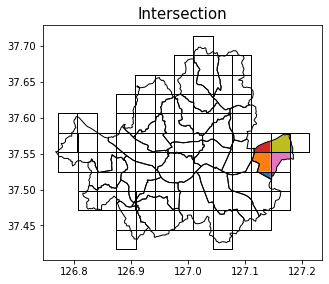

In [44]:
intersection = gpd.overlay(grid3000, gu_json.iloc[[0]], how='intersection')
ax = intersection.plot(figsize=(5,5),cmap='tab10')
grid3000.plot(ax=ax, facecolor='none', edgecolor='k')
gu_json.plot(ax=ax, facecolor='none', edgecolor='k')
plt.title("Intersection", fontsize=15)
plt.show()

In [32]:
m = folium.Map(location=[37.5642135, 127.0016985], zoom_start=11)

sim_geo = gpd.GeoSeries(grid3000['geometry'], grid3000['index'])
geo_j = sim_geo.to_json()

folium.Choropleth(
    geo_data=geo_j,
    data=grid3000,
    columns=['index', 'restaurants'],
    key_on='id',
    fill_color='YlGnBu'
).add_to(m)



for _, r in grid3000.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo_new = gpd.GeoSeries(r['geometry'])
    geo_j_new = sim_geo_new.to_json()
    geo_j_new = folium.GeoJson(data=geo_j_new, style_function=lambda x:{'fillColor': '#FF000000', 'color': '#FF000000'})
    folium.Popup(str(r['restaurants'])).add_to(geo_j_new)
    geo_j_new.add_to(m)

m

In [33]:
family_gu = pd.read_csv('family_gu.csv')
family_gu = family_gu.iloc[:,1:]
family_gu = family_gu.reindex(sorted(family_gu.columns), axis=1)
family_gu

,강남구,강동구,강북구,강서구,관악구,광진구,구로구,금천구,노원구,도봉구,...,성동구,성북구,송파구,양천구,영등포구,용산구,은평구,종로구,중구,중랑구
0,71986,56905,48428,94436,136255,66140,54980,46827,60647,37853,...,44946,64985,79262,42973,69806,39270,62447,27308,24544,60487


In [34]:
family_grid = grid_gu.dot(family_gu.transpose())
family_grid.rename(columns = {0: '1인가구수'}, inplace=True)
family_grid

,1인가구수
0,36723.749742
1,63495.277990
2,11691.158007
3,27671.530207
4,17666.975830
...,...
79,25590.970066
80,6573.407297
81,35405.981069
82,44640.283458


In [35]:
grid3000['1인가구수'] = family_grid['1인가구수']

m = folium.Map(location=[37.5642135, 127.0016985], zoom_start=11)

sim_geo = gpd.GeoSeries(grid3000['geometry'], grid3000['index'])
geo_j = sim_geo.to_json()

folium.Choropleth(
    geo_data=geo_j,
    data=grid3000,
    columns=['index', '1인가구수'],
    key_on='id',
    fill_color='YlGnBu'
).add_to(m)



for _, r in grid3000.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo_new = gpd.GeoSeries(r['geometry'])
    geo_j_new = sim_geo_new.to_json()
    geo_j_new = folium.GeoJson(data=geo_j_new, style_function=lambda x:{'fillColor': '#FF000000', 'color': '#FF000000'})
    folium.Popup(str(r['1인가구수'])).add_to(geo_j_new)
    geo_j_new.add_to(m)

m

In [36]:
bike_gu = pd.read_csv('bike_gu.csv')
bike_gu = bike_gu.reindex(sorted(bike_gu.columns), axis=1)

bike_grid = grid_gu.dot(bike_gu.transpose())
bike_grid.rename(columns = {0: '오토바이 등록대수'}, inplace=True)

bike_grid

,오토바이 등록대수
0,73410.945284
1,126927.353852
2,23370.678834
3,67413.746282
4,54320.884312
...,...
79,75701.319402
80,18180.394667
81,90010.397281
82,113486.183056


In [37]:
grid3000['오토바이 등록대수'] = bike_grid['오토바이 등록대수']

m = folium.Map(location=[37.5642135, 127.0016985], zoom_start=11)

sim_geo = gpd.GeoSeries(grid3000['geometry'], grid3000['index'])
geo_j = sim_geo.to_json()

folium.Choropleth(
    geo_data=geo_j,
    data=grid3000,
    columns=['index', '오토바이 등록대수'],
    key_on='id',
    fill_color='YlGnBu'
).add_to(m)



for _, r in grid3000.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo_new = gpd.GeoSeries(r['geometry'])
    geo_j_new = sim_geo_new.to_json()
    geo_j_new = folium.GeoJson(data=geo_j_new, style_function=lambda x:{'fillColor': '#FF000000', 'color': '#FF000000'})
    folium.Popup(str(r['오토바이 등록대수'])).add_to(geo_j_new)
    geo_j_new.add_to(m)

m

In [38]:
bba = pd.read_csv('bikeBatteryAnalysis.csv')
bba = bba[(bba['lat']!=0) & (bba['lon'] != 0)]
bba = bba.iloc[:,1:].reset_index(drop=True)
bba

,biSerial,time,status,bt1Soc,bt2Soc,lat,lon
0,M2226B0018,2023-04-05 06:15:45,1,533,523,37.484455,127.034402
1,MZBATB0543,2023-04-05 06:15:29,1,836,835,37.521858,127.048508
2,M2226B0011,2023-04-05 06:15:25,1,787,788,37.505485,127.020012
3,M2226B0022,2023-04-05 06:15:22,1,877,871,37.524872,127.024170
4,MZBAGB0550,2023-04-05 06:15:17,1,940,940,37.504578,127.010253
...,...,...,...,...,...,...,...
873958,M2226B0020,2022-12-31 18:02:40,1,581,578,37.465740,126.936692
873959,M2226B0022,2022-12-31 17:52:26,1,911,910,37.521633,127.048050
873960,MZBAYB0538,2022-12-31 15:00:00,1,644,639,37.508778,127.026970
873961,M2134D0008,2022-12-31 13:31:12,1,308,308,37.357587,126.950180


In [39]:
bba_tf = transform(proj_4326, proj_2097, bba['lon'], bba['lat'])
df_tf = pd.DataFrame(bba_tf)
df_tf = df_tf.transpose()
df_tf['x_grid'] = (df_tf[0] -180000)//3000
df_tf['y_grid'] = (df_tf[1] -435000)//3000
df_tf['x_error'] = np.where((df_tf['x_grid']>= 0) & (df_tf['x_grid'] <= 13), "No", "Yes")
df_tf['y_error'] = np.where((df_tf['y_grid']>= 0) & (df_tf['y_grid'] <= 11), "No", "Yes")
df_tf['error'] = np.where((df_tf['x_error'] == 'No') & (df_tf['y_error'] == 'No'), "No", "Yes")
df_tf['grid'] = df_tf['x_grid']*12 + df_tf['y_grid']
df_tf

C:\Users\lotto\AppData\Local\Temp/ipykernel_15836/4099349037.py:1: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  bba_tf = transform(proj_4326, proj_2097, bba['lon'], bba['lat'])


,0,1,x_grid,y_grid,x_error,y_error,error,grid
0,203228.491660,442474.148647,7.0,2.0,No,No,No,86.0
1,204473.948475,446626.037819,8.0,3.0,No,No,No,99.0
2,201955.245187,444807.836808,7.0,3.0,No,No,No,87.0
3,202322.339630,446959.620365,7.0,3.0,No,No,No,87.0
4,201092.428771,444707.056322,7.0,3.0,No,No,No,87.0
...,...,...,...,...,...,...,...,...
873958,194585.214375,440398.218125,4.0,1.0,No,No,No,49.0
873959,204433.444749,446601.044053,8.0,3.0,No,No,No,99.0
873960,202570.388812,445173.520107,7.0,3.0,No,No,No,87.0
873961,195772.315346,428393.982426,5.0,-3.0,No,Yes,Yes,57.0


In [16]:
bba['grid'] = df_tf['grid']
bba_filtered = bba[df_tf['error'] == 'No']
bba_filtered['grid'] = bba_filtered['grid'].astype(int)
bba_filtered

C:\Users\lotto\AppData\Local\Temp/ipykernel_15836/580886863.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bba_filtered['grid'] = bba_filtered['grid'].astype(int)


,biSerial,time,status,bt1Soc,bt2Soc,lat,lon,grid
0,M2226B0018,2023-04-05 06:15:45,1,533,523,37.484455,127.034402,86
1,MZBATB0543,2023-04-05 06:15:29,1,836,835,37.521858,127.048508,99
2,M2226B0011,2023-04-05 06:15:25,1,787,788,37.505485,127.020012,87
3,M2226B0022,2023-04-05 06:15:22,1,877,871,37.524872,127.024170,87
4,MZBAGB0550,2023-04-05 06:15:17,1,940,940,37.504578,127.010253,87
...,...,...,...,...,...,...,...,...
873953,M2227Y0008,2023-01-01 00:46:03,1,438,437,37.507080,127.056892,99
873954,M2226B0042,2023-01-01 00:35:38,1,473,476,37.508507,127.038232,87
873958,M2226B0020,2022-12-31 18:02:40,1,581,578,37.465740,126.936692,49
873959,M2226B0022,2022-12-31 17:52:26,1,911,910,37.521633,127.048050,99


In [40]:
serial = bba_filtered['biSerial'].unique()

sample = bba_filtered[bba_filtered['biSerial'] == serial[0]]
sample['changed'] = sample['grid'].diff()
sample['changed'] = sample['changed'].fillna(1)
sample_filtered = sample[sample['changed'] != 0]
sample_filtered

C:\Users\lotto\AppData\Local\Temp/ipykernel_15836/3464425483.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['changed'] = sample['grid'].diff()
C:\Users\lotto\AppData\Local\Temp/ipykernel_15836/3464425483.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['changed'] = sample['changed'].fillna(1)


,biSerial,time,status,bt1Soc,bt2Soc,lat,lon,grid,changed
0,M2226B0018,2023-04-05 06:15:45,1,533,523,37.484455,127.034402,86,1.0
156,M2226B0018,2023-04-05 05:55:00,1,582,572,37.499150,127.033607,87,1.0
219,M2226B0018,2023-04-05 05:46:43,1,606,596,37.496167,127.039893,86,-1.0
439,M2226B0018,2023-04-05 05:19:44,1,681,671,37.499523,127.012757,87,1.0
565,M2226B0018,2023-04-05 05:05:13,1,711,702,37.507523,127.009170,75,-12.0
...,...,...,...,...,...,...,...,...,...
873515,M2226B0018,2023-01-03 00:47:30,1,853,852,37.501782,127.040367,87,-12.0
873525,M2226B0018,2023-01-03 00:45:10,1,880,880,37.497895,127.027520,86,-1.0
873574,M2226B0018,2023-01-03 00:33:11,1,914,920,37.500458,127.042740,87,1.0
873591,M2226B0018,2023-01-03 00:28:26,1,0,942,37.504498,127.048690,99,12.0


In [105]:
sample_count = pd.DataFrame(sample_filtered['grid'].value_counts())
sample_count

,grid
86,773
87,656
74,292
99,176
62,123
50,119
98,109
77,82
76,74
38,60


In [106]:
sample2 = bba_filtered[bba_filtered['biSerial'] == serial[1]]
sample2['changed'] = sample2['grid'].diff()
sample2['changed'] = sample2['changed'].fillna(1)
sample_filtered2 = sample2[sample2['changed'] != 0]
sample_filtered2

C:\Users\lotto\AppData\Local\Temp/ipykernel_248772/4261605171.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample2['changed'] = sample2['grid'].diff()
C:\Users\lotto\AppData\Local\Temp/ipykernel_248772/4261605171.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample2['changed'] = sample2['changed'].fillna(1)


,biSerial,time,status,bt1Soc,bt2Soc,lat,lon,grid,changed
1,MZBATB0543,2023-04-05 06:15:29,1,836,835,37.521858,127.048508,99,1.0
307,MZBATB0543,2023-04-05 05:35:43,1,860,847,37.523117,127.038918,87,-12.0
411,MZBATB0543,2023-04-05 05:23:16,1,901,895,37.526707,127.028373,88,1.0
453,MZBATB0543,2023-04-05 05:17:05,1,935,932,37.523087,127.026543,87,-1.0
573,MZBATB0543,2023-04-05 05:04:38,1,994,994,37.510285,127.043702,99,12.0
...,...,...,...,...,...,...,...,...,...
872261,MZBATB0543,2023-01-03 03:09:44,1,966,967,37.516598,127.046845,99,12.0
872671,MZBATB0543,2023-01-03 02:40:42,1,673,670,37.508918,127.038643,87,-12.0
872732,MZBATB0543,2023-01-03 02:36:03,1,709,707,37.503505,127.044228,99,12.0
872940,MZBATB0543,2023-01-03 02:18:59,1,804,801,37.527958,127.055793,100,1.0


In [107]:
sample_count2 = pd.DataFrame(sample_filtered2['grid'].value_counts())
sample_count2

,grid
99,1019
87,807
98,459
88,230
86,218
100,202
85,6
111,3
97,3
75,3


In [41]:
grid_traffic = pd.DataFrame([0], columns={'grid'})

for se in serial:
    df = bba_filtered[bba_filtered['biSerial'] == se]
    df['changed'] = df['grid'].diff()
    df['changed'] = df['changed'].fillna(1)
    df_fil = df[df['changed'] != 0]
    grid_traffic = pd.concat([grid_traffic, pd.DataFrame(df_fil['grid'].value_counts())], axis=1).fillna(0).sum(axis=1)

grid_traffic = pd.DataFrame(grid_traffic, columns={'traffic'})
grid_traffic

C:\Users\lotto\AppData\Local\Temp/ipykernel_15836/4189695740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['changed'] = df['grid'].diff()
C:\Users\lotto\AppData\Local\Temp/ipykernel_15836/4189695740.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['changed'] = df['changed'].fillna(1)


,traffic
0,0.0
2,1.0
3,1.0
4,1.0
5,1.0
...,...
151,4.0
152,2.0
160,130.0
164,4.0


In [42]:
grid_traffic['index_before'] = grid_traffic.index
grid_traffic

,traffic,index_before
0,0.0,0
2,1.0,2
3,1.0,3
4,1.0,4
5,1.0,5
...,...,...
151,4.0,151
152,2.0,152
160,130.0,160
164,4.0,164


In [43]:
grid3000 = pd.merge(grid3000, grid_traffic, on='index_before', how='left')
grid3000['traffic'] = grid3000['traffic'].fillna(0)
grid3000

,geometry,index_before,restaurants,index,1인가구수,오토바이 등록대수,traffic
0,"POLYGON ((126.77165 37.52502, 126.77165 37.552...",4,5,0,36723.749742,73410.945284,1.0
1,"POLYGON ((126.77156 37.55205, 126.77156 37.579...",5,151,1,63495.277990,126927.353852,1.0
2,"POLYGON ((126.77148 37.57908, 126.77148 37.606...",6,2,2,11691.158007,23370.678834,0.0
3,"POLYGON ((126.80572 37.47102, 126.80572 37.498...",14,300,3,27671.530207,67413.746282,25.0
4,"POLYGON ((126.80565 37.49805, 126.80565 37.525...",15,367,4,17666.975830,54320.884312,39.0
...,...,...,...,...,...,...,...
79,"POLYGON ((127.14486 37.47109, 127.14486 37.498...",134,237,79,25590.970066,75701.319402,804.0
80,"POLYGON ((127.14491 37.49812, 127.14491 37.525...",135,73,80,6573.407297,18180.394667,583.0
81,"POLYGON ((127.14496 37.52515, 127.14496 37.552...",136,231,81,35405.981069,90010.397281,83.0
82,"POLYGON ((127.14502 37.55218, 127.14502 37.579...",137,339,82,44640.283458,113486.183056,22.0


In [44]:
grid3000['traffic_scale'] = grid3000['traffic']
grid3000 = grid3000.replace({'traffic_scale' : 0}, 0.1)
grid3000['traffic_scale'] = np.log(grid3000['traffic_scale'])
grid3000

,geometry,index_before,restaurants,index,1인가구수,오토바이 등록대수,traffic,traffic_scale
0,"POLYGON ((126.77165 37.52502, 126.77165 37.552...",4,5,0,36723.749742,73410.945284,1.0,0.000000
1,"POLYGON ((126.77156 37.55205, 126.77156 37.579...",5,151,1,63495.277990,126927.353852,1.0,0.000000
2,"POLYGON ((126.77148 37.57908, 126.77148 37.606...",6,2,2,11691.158007,23370.678834,0.0,-2.302585
3,"POLYGON ((126.80572 37.47102, 126.80572 37.498...",14,300,3,27671.530207,67413.746282,25.0,3.218876
4,"POLYGON ((126.80565 37.49805, 126.80565 37.525...",15,367,4,17666.975830,54320.884312,39.0,3.663562
...,...,...,...,...,...,...,...,...
79,"POLYGON ((127.14486 37.47109, 127.14486 37.498...",134,237,79,25590.970066,75701.319402,804.0,6.689599
80,"POLYGON ((127.14491 37.49812, 127.14491 37.525...",135,73,80,6573.407297,18180.394667,583.0,6.368187
81,"POLYGON ((127.14496 37.52515, 127.14496 37.552...",136,231,81,35405.981069,90010.397281,83.0,4.418841
82,"POLYGON ((127.14502 37.55218, 127.14502 37.579...",137,339,82,44640.283458,113486.183056,22.0,3.091042


In [45]:
m = folium.Map(location=[37.5642135, 127.0016985], zoom_start=11)

sim_geo = gpd.GeoSeries(grid3000['geometry'], grid3000['index'])
geo_j = sim_geo.to_json()

folium.Choropleth(
    geo_data=geo_j,
    data=grid3000,
    columns=['index', 'traffic_scale'],
    key_on='id',
    fill_color='YlGnBu'
).add_to(m)



for _, r in grid3000.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo_new = gpd.GeoSeries(r['geometry'])
    geo_j_new = sim_geo_new.to_json()
    geo_j_new = folium.GeoJson(data=geo_j_new, style_function=lambda x:{'fillColor': '#FF000000', 'color': '#FF000000'})
    folium.Popup(str(r['traffic_scale'])).add_to(geo_j_new)
    geo_j_new.add_to(m)

m

In [46]:
grid3000.iloc[:,4:].corr()

,1인가구수,오토바이 등록대수,traffic,traffic_scale
1인가구수,1.000000,0.697874,0.193764,0.458954
오토바이 등록대수,0.697874,1.000000,0.513359,0.607830
traffic,0.193764,0.513359,1.000000,0.506729
traffic_scale,0.458954,0.607830,0.506729,1.000000


In [49]:
grid3000.to_csv('grid3000.csv')

In [48]:
m = folium.Map(location=[37.5642135, 127.0016985], zoom_start=11)

geo_str = json.load(open('gu.json', encoding='utf-8'))
folium.Choropleth(
    geo_data=geo_str,
).add_to(m)

folium.Choropleth(
    geo_data=geo_j,
    fill_color='YlGnBu'
).add_to(m)

for _, r in grid3000.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo_new = gpd.GeoSeries(r['geometry'])
    geo_j_new = sim_geo_new.to_json()
    geo_j_new = folium.GeoJson(data=geo_j_new, style_function=lambda x:{'fillColor': '#FF000000', 'color': '#FF000000'})
    folium.Popup(str(r['index'])).add_to(geo_j_new)
    geo_j_new.add_to(m)

m

In [3]:
# 위경도 그리드 변환 함수

NX = 149            ## X축 격자점 수
NY = 253            ## Y축 격자점 수

Re = 6371.00877     ##  지도반경
grid = 0.5          ##  격자간격 (km)
slat1 = 30.0        ##  표준위도 1
slat2 = 60.0        ##  표준위도 2
olon = 126.0        ##  기준점 경도
olat = 38.0         ##  기준점 위도
xo = 210 / grid     ##  기준점 X좌표
yo = 675 / grid     ##  기준점 Y좌표
first = 0

if first == 0 :
    PI = math.asin(1.0) * 2.0
    DEGRAD = PI/ 180.0
    RADDEG = 180.0 / PI


    re = Re / grid
    slat1 = slat1 * DEGRAD
    slat2 = slat2 * DEGRAD
    olon = olon * DEGRAD
    olat = olat * DEGRAD

    sn = math.tan(PI * 0.25 + slat2 * 0.5) / math.tan(PI * 0.25 + slat1 * 0.5)
    sn = math.log(math.cos(slat1) / math.cos(slat2)) / math.log(sn)
    sf = math.tan(PI * 0.25 + slat1 * 0.5)
    sf = math.pow(sf, sn) * math.cos(slat1) / sn
    ro = math.tan(PI * 0.25 + olat * 0.5)
    ro = re * sf / math.pow(ro, sn)
    first = 1

def mapToGrid(lat, lon, code = 0 ):
    ra = math.tan(PI * 0.25 + lat * DEGRAD * 0.5)
    ra = re * sf / pow(ra, sn)
    theta = lon * DEGRAD - olon
    if theta > PI :
        theta -= 2.0 * PI
    if theta < -PI :
        theta += 2.0 * PI
    theta *= sn
    x = (ra * math.sin(theta)) + xo
    y = (ro - ra * math.cos(theta)) + yo
    x = int(x + 1.5)
    y = int(y + 1.5)
    return x, y

def gridToMap(x, y, code = 1):
    x = x - 1
    y = y - 1
    xn = x - xo
    yn = ro - y + yo
    ra = math.sqrt(xn * xn + yn * yn)
    if sn < 0.0 :
        ra = -ra
    alat = math.pow((re * sf / ra), (1.0 / sn))
    alat = 2.0 * math.atan(alat) - PI * 0.5
    if math.fabs(xn) <= 0.0 :
        theta = 0.0
    else :
        if math.fabs(yn) <= 0.0 :
            theta = PI * 0.5
            if xn < 0.0 :
                theta = -theta
        else :
            theta = math.atan2(xn, yn)
    alon = theta / sn + olon
    lat = alat * RADDEG
    lon = alon * RADDEG

    return lat, lon

print(mapToGrid(37.579871128849334, 126.98935225645432))
print(mapToGrid(35.101148844565955, 129.02478725562108))
print(mapToGrid(33.500946412305076, 126.54663058817043))

(591, 1261)
(961, 731)
(521, 371)
